# Deviation Detection Tool

In this notebook, we present a tool for detecting windows of a timeseries that deviate significantly from a learned model. Given a set of intervals where there is a behaviour we want to examine, we can train a model on those intervals and then search for regions that their behaviour deviates significantly from our model.

We focus on a particular use case, where each point in the input time series contains measurements for power production and various environmental parameters in a solar panel park. Specifically in this task we aim to detect regions of the timeseries that underperform due to soiling.

Towards that goal, we train a regression model on regions that we are confident that the solar panels are not soiled (they have been washed). Afterwards, assuming that the model sufficiently captures the behaviour of the park when there is no soiling , we use that model to detect the windows that exhibit the most significant deviation from the expected 'clean' behaviour we get from the model.

## Load libraries used

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from matplotlib import pyplot as plt
from my_functions import *
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
%matplotlib inline 

## Load the input timeseries
Here, we load a dataset that cointains measurments from a solar panel park that span  3 years (2019-2021, on the array level), as well as the respective weather conditions observed at each measurement time. We also perform some preprocessing steps such as keeping measurements during a specific interval of each day i.e. 10:00-16:00.

In [2]:
file_strings2020 = "/data/inaccess/new_29_9_20/PV1 -20200101T000000v0/PV1 -20200101T000000_msrc15m.csv"
file_strings2019 = "/data/inaccess/new_29_9_20/PV 1-20190101T000000/PV 1-20190101T000000_msrc15m.csv"

df_strings = pd.concat([pd.read_csv(file_strings2019),pd.read_csv(file_strings2020)])[['Panel group output power (kW) [Array 1]','Total Irradiance (W*m^-2) [Array 1]', 'Performance index (to date) (%) [Array 1]',  'Module Temperature (C) [Array 1]']]
df_strings = df_strings.rename_axis('timestamp')
df_strings.columns = [ 'power', 'irradiance', 'perf_index', 'mod_temp']
df_strings.index = pd.to_datetime(df_strings.index)

start = '10:00'
end = '16:00'
df_strings = df_strings.between_time(start, end)

df_strings_clean = df_strings.dropna()
df_strings_clean = df_strings_clean.drop_duplicates()
scaler = MinMaxScaler()
df_strings_clean = pd.DataFrame(scaler.fit_transform(df_strings_clean), columns=df_strings_clean.columns, index=df_strings_clean.index)
df = df_strings_clean


## Train on time intervals after reference points (washing events in this specific scenario)
At this point we are going to fit our linear model to region after some specific refrence points in the time series. We assume that for a window of $ w\_train $ days after each point, the time series exhibits the behaviour we want to learn (Operation of the solar panels while they are clean in this specific scenario). 
We also keep a subset of the points in those regions as a validation set in order to check how well our model learned that specific behaviour. In order to obtain the training and the validation sets we merge the windows after each reference point, shuffle the entire resulting set and take 80% as the training and 20% as the validation set. The features we use and the target variable are usually domain specific.

In [3]:
w_train = 30
ref_points = pd.Index(['2021-04-19 00:00:00', '2020-10-26 00:00:00', '2020-06-05 00:00:00', '2019-07-29 00:00:00', '2019-05-28 00:00:00'])
print(f'The number of reference points (washing events in this case) is : {len(ref_points)} \n')
feats =  ['irradiance', 'mod_temp', 'perf_index']
target = 'power'
model, training_scores, validation_scores = train_on_reference_points(df, w_train, ref_points, feats, target)

The number of reference points (washing events in this case) is : 5 

Training Metrics:
MAE:0.009 
ME(true-pred):-0.000 
MAPE:0.013 
R2: 0.992

Validation Metrics:
MAE:0.009 
ME(true-pred):-0.000 
MAPE:0.013 
MPE:-0.001 
R2: 0.992



Based on the metrics above our model seems to be able to fit really well the washed regions.

## Make predictions on a sliding window on the entirety of the timeseries

Now, by using the model, which we have trained on the refrence points, we are going to predict on any possible sliding window given a window size and a step, aiming to detect a time window where expected/predicted values deviate significantly from the true values. More specifically, for the use case we are demonstrating here, we want to find segments where the True Power is significantly lower than the Expected Power, intuitively this signifies that we are at a segment where the panels perform worse than what we expect from "clean" panels.

In [4]:
window = 90
step = 30
scores, preds_test, windows = predict_on_sliding_windows(df, window, step, model, feats, target)

## Rank and plot the most indicative windows

In the next cell we are going to rank all the possible windows that we have examined, according to a score that represents their deviation from the learned model. For this demonstration, we are using the Mean Percentage Error in order to score the various windows. Afterwards scoring, we are going to plot the 5 most deviant cases together with some usefull metrics. We will also plot a graph that depicts the evolution of the difference $ True Power - Expected Power $, since in this particular case we are looking at soiling, that is a gradual process we expect to see a gradual negative trend.

----------------------------------------------Case #1-----------------------------------------------


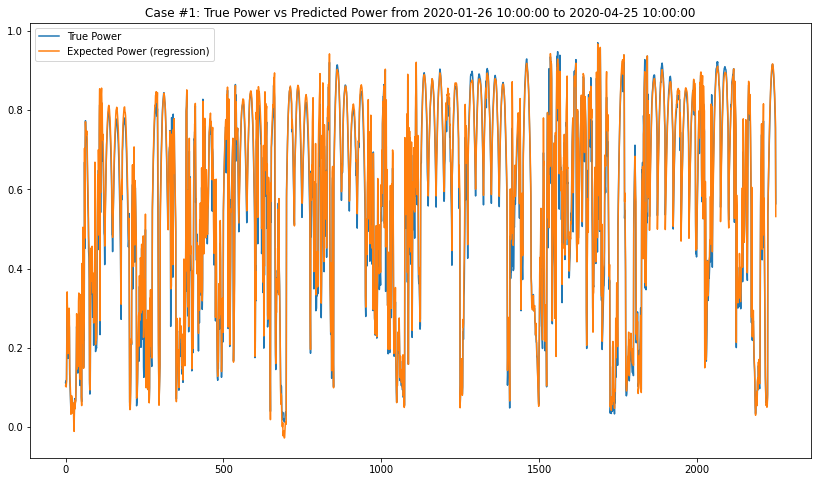

For this window the True Power is different from the Expected Power by: -2.925% on average

Other relevant Metrics:
MAE:0.025  
ME(true-pred):-0.017 
MAPE:0.043 
R2: 0.982



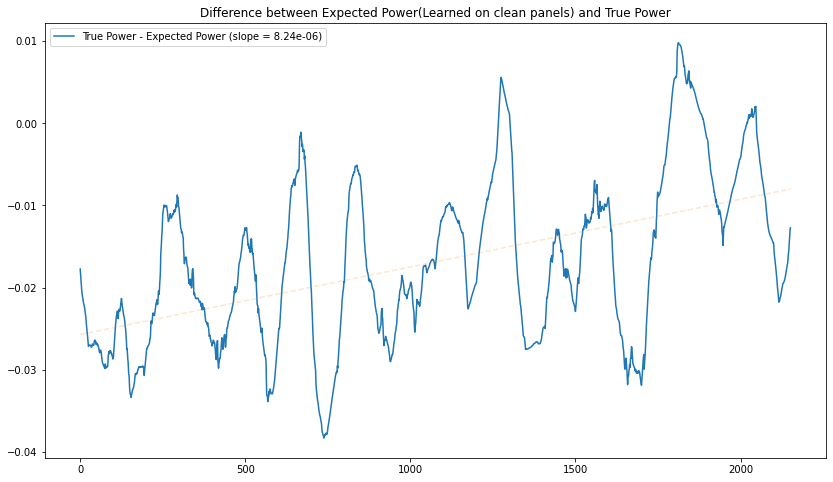

----------------------------------------------Case #2-----------------------------------------------


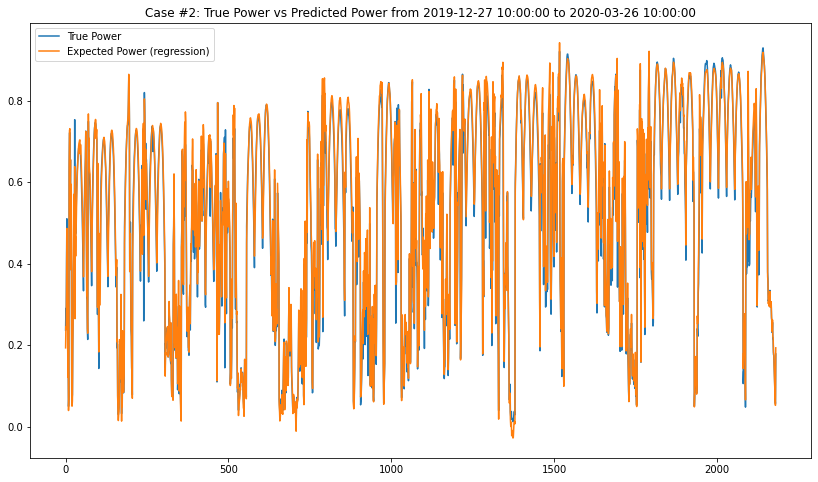

For this window the True Power is different from the Expected Power by: -2.898% on average

Other relevant Metrics:
MAE:0.024  
ME(true-pred):-0.015 
MAPE:0.046 
R2: 0.981



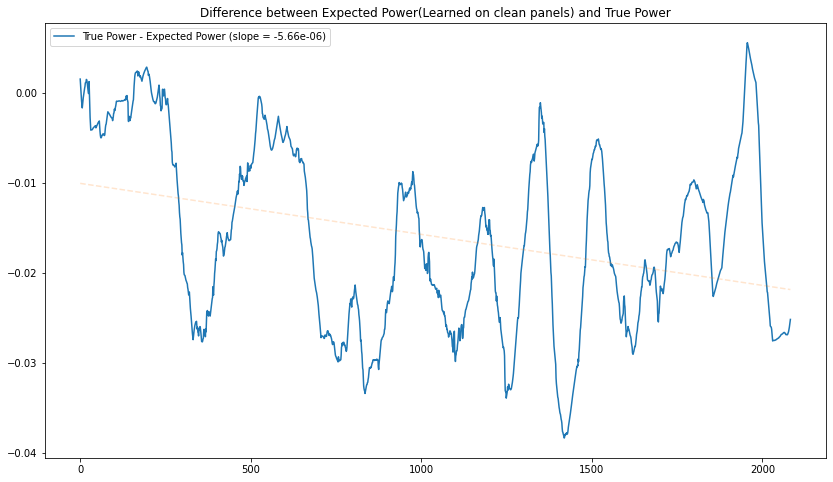

----------------------------------------------Case #3-----------------------------------------------


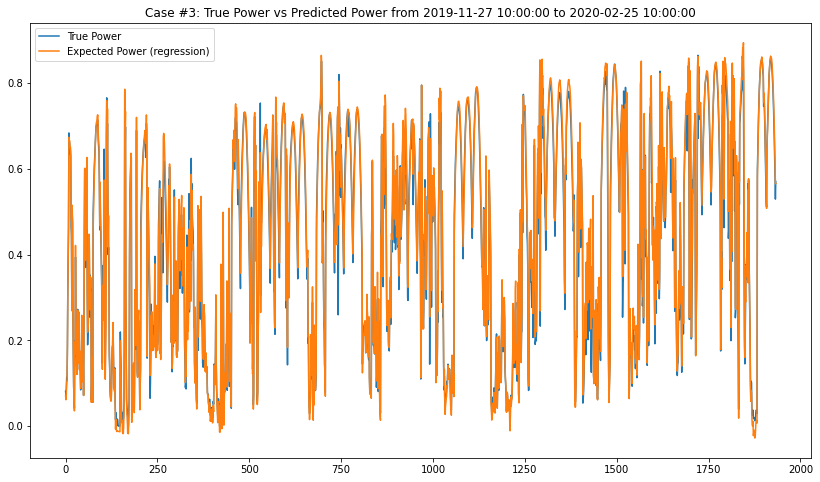

For this window the True Power is different from the Expected Power by: -2.515% on average

Other relevant Metrics:
MAE:0.023  
ME(true-pred):-0.011 
MAPE:0.054 
R2: 0.981



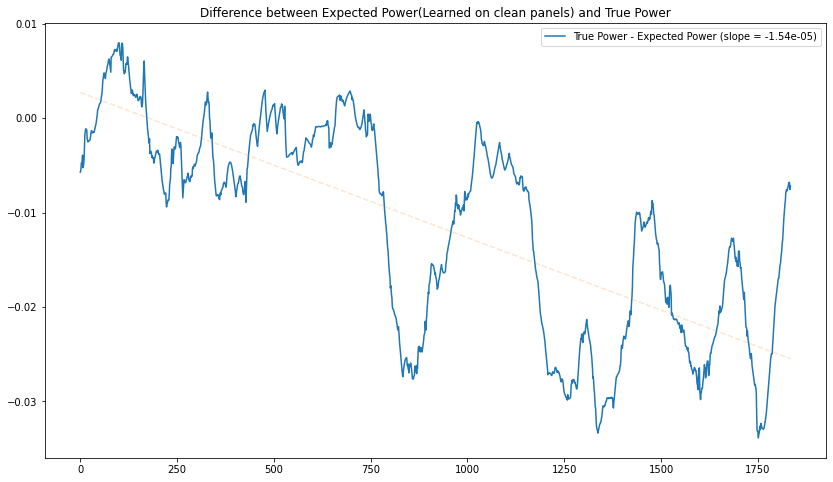

----------------------------------------------Case #4-----------------------------------------------


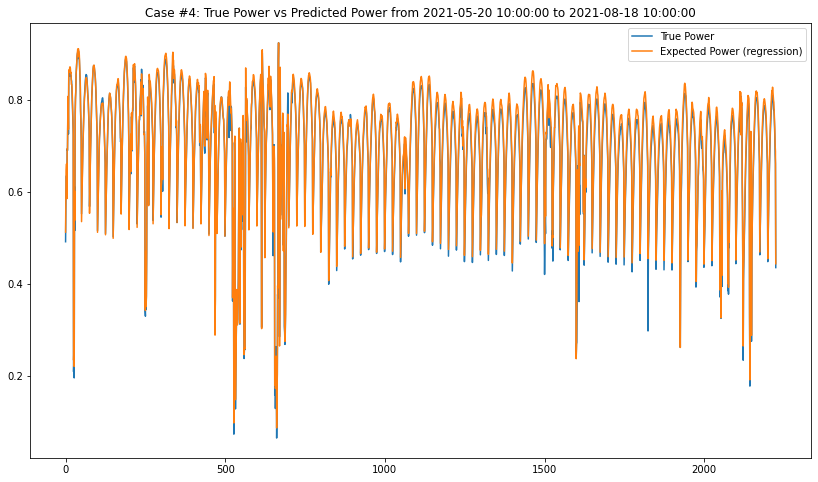

For this window the True Power is different from the Expected Power by: -1.654% on average

Other relevant Metrics:
MAE:0.013  
ME(true-pred):-0.012 
MAPE:0.019 
R2: 0.982



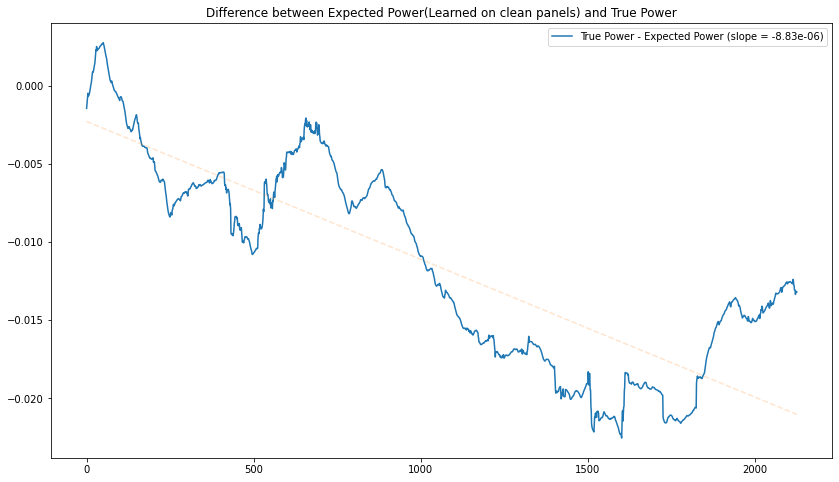

----------------------------------------------Case #5-----------------------------------------------


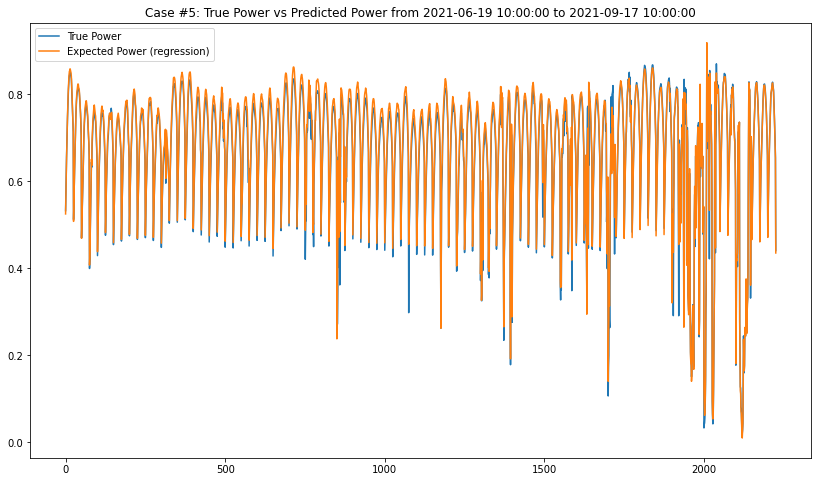

For this window the True Power is different from the Expected Power by: -1.613% on average

Other relevant Metrics:
MAE:0.015  
ME(true-pred):-0.011 
MAPE:0.022 
R2: 0.978



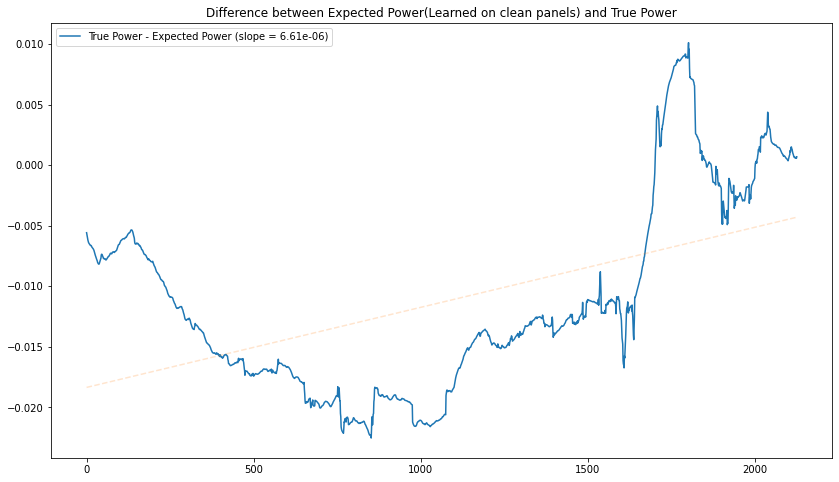

The average quality measures on all the above cases are:
MAE:0.020  
ME(true-pred):-0.013 
MAPE:0.037 
MPE: -0.023 
R2: 0.981



In [5]:
indices = get_top_deviations(scores, 'mpe')

slopes = []

for n, i in enumerate(indices):
    d1, window_after= windows[i]
    print(f"Case #{n + 1}".center(100,"-"))
    plt.figure(figsize=(14,8))
    plt.title(f"Case #{n + 1}: True Power vs Predicted Power from {d1} to {window_after}")
    plt.plot(df_strings_clean.loc[d1:window_after].power.values, label="True Power")
    
    preds = preds_test[i]
    plt.plot(preds, label="Expected Power (regression)")
    plt.legend()
    plt.show()
    
    print(f"For this window the True Power is different from the Expected Power by: {(scores[i, 4] * 100):.3f}% on average\n")
    
    print('Other relevant Metrics:')
    print(f'MAE:{scores[i, 1]:.3f}  \nME(true-pred):{scores[i,2]:.3f} \nMAPE:{scores[i, 3]:.3f} \nR2: {scores[i, 0]:.3f}\n')
    
    plt.figure(figsize=(14,8))
    plt.title(f"Difference between Expected Power(Learned on clean panels) and True Power")
    roll = 100
    if len(preds) <= roll:
        continue
    diff = (df_strings_clean.loc[d1:window_after].power - preds).rolling(roll).mean().dropna().values
    line , slope, _ = get_line_and_slope(diff)
    slopes.append(slope)
    
    plt.plot(diff, label=f"True Power - Expected Power (slope = {slope:.3g})")
    plt.plot(line, linestyle='dashed', alpha = 0.2)
    plt.legend()
    plt.show()

avg_scores = scores[indices].mean(axis=0)  # column wise mean for each score
print('The average quality measures on all the above cases are:')
print(f'MAE:{avg_scores[1]:.3f}  \nME(true-pred):{avg_scores[2]:.3f} \nMAPE:{avg_scores[3]:.3f} \nMPE: {avg_scores[4]:.3f} \nR2: {avg_scores[0]:.3f}\n')

windows = np.array(windows)
df_stats = pd.DataFrame.from_dict({'Score (Mean Percentage Error)':scores[indices, 4],
                                   'Window Starting Date': windows[indices, 0],
                                   'Window Ending Date': windows[indices, 1],
                                   'Slope': slopes})
 

# Table of stats for the top cases

In [6]:
df_stats

,Score (Mean Percentage Error),Window Starting Date,Window Ending Date,Slope
0,-0.029248,2020-01-26 10:00:00,2020-04-25 10:00:00,0.000008
1,-0.028984,2019-12-27 10:00:00,2020-03-26 10:00:00,-0.000006
2,-0.025145,2019-11-27 10:00:00,2020-02-25 10:00:00,-0.000015
3,-0.016539,2021-05-20 10:00:00,2021-08-18 10:00:00,-0.000009
4,-0.016132,2021-06-19 10:00:00,2021-09-17 10:00:00,0.000007
